## NI-MVI semestrální práce upscaling

In [1]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    GOOGLE_COLAB = True
except:
    GOOGLE_COLAB = False


In [2]:
import cv2

from tensorflow.data import Dataset

if GOOGLE_COLAB:
    from google.colab.patches import cv2_imshow
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

import numpy as np
import pickle as pk
import tensorflow as tf
from tensorflow.keras import optimizers, losses
import keras
from keras.callbacks import ModelCheckpoint

tf.__version__


tf.config.run_functions_eagerly = True


In [3]:
# získání framů z videa

filepath = "/content/drive/MyDrive/colab_notebooks/semestral/video/"
if not GOOGLE_COLAB:
    filepath = "./video/"

img_width = 320
img_height = 256

# Set False to load trained weights from the memory
TRAIN_UNET = False
TRAIN_GAN = False


def frame_predict(model, f, s):
    input = np.concatenate((f, s), axis=-1)
    input = np.expand_dims(input, axis=0)
    pred = model.predict(input)[0, :, :, :]
    pred = pred * 255
    return pred.astype(np.uint8)


def normalize_frame(frame, width, height):
    dim = (width, height)
    frame = cv2.resize(frame, dim)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = tf.cast(frame, tf.float32)
    frame = frame / 255.0

    # frame = np.swapaxes(frame, 0, 2)
    return frame


def frame_gen(f):
    count = 0
    cap = cv2.VideoCapture(f)
    success = True
    while success:
        success, image = cap.read()
        if success:
            count += 1
            image = normalize_frame(image, img_width, img_height)
            yield image
    cap.release()


def dataset_generator():
    for f in ["batman_cut.mp4", "castelvania_cut.mkv", "jekyll_cut.mkv"]:
        g = frame_gen(filepath + f)
        try:
            first, second, third = next(g), next(g), next(g)
            yield np.concatenate((first, third), axis=-1), second
            while True:
                first = second
                second = third
                third = next(g)
                yield np.concatenate((first, third), axis=-1), second
        except StopIteration:
            return


d = Dataset.from_generator(
    dataset_generator,
    output_signature=(
        tf.TensorSpec(shape=(img_height, img_width, 6), dtype=tf.float64),
        tf.TensorSpec(shape=(img_height, img_width, 3), dtype=tf.float64),
    ),
)

d = d.batch(8)

d_val = d.take(3)
d_train = d.skip(3)



2021-12-30 09:27:25.772781: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-30 09:27:25.776388: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
from unet_model import unet_model

unet_m = unet_model()
unet_m.compile(optimizer="adam", loss="mse", run_eagerly=True)



In [5]:
unet_m.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 320, 6) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 320, 32) 1760        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 320, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 320, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
from gan_model import generator, discriminator, FrameGAN


gen = generator()
disc = discriminator()

# disc.summary()

gan = FrameGAN(gen, disc)
gan.compile(
    disc_opt=optimizers.Adam(learning_rate=0.00001),
    gen_opt=optimizers.Adam(learning_rate=0.0007),
    loss_fn=losses.BinaryCrossentropy(),
)


In [7]:
test_frame_gen = frame_gen(filepath + "castelvania_cut.mkv")

first, second = next(test_frame_gen), next(test_frame_gen)


class ShowImageFromBatch(keras.callbacks.Callback):
    def __init__(self, first, second):
        self.first = first
        self.second = second

    def on_epoch_end(self, epoch, logs=None):
        new_frame = frame_predict(self.model.gen, first, second)
        cv2_imshow(new_frame)


show_img_callback = ShowImageFromBatch(first, second)

weights_path = "./weights/"
history_path = "./history/"

unet_weights = weights_path + "unet/unet_weights"
unet_history = None
unet_train_history = history_path + "unet_train_history"

gan_weights = weights_path + "gan/gan_weights_callback"
gan_history = None
gan_train_history = history_path + "gan_train_history"


if TRAIN_GAN:
    checkpoint = ModelCheckpoint(
        filepath=gan_weights,
        save_best_only=True,
        save_weights_only=True,
        monitor="ssim_accuracy",
    )
    res = gan.fit(d_train, epochs=150, callbacks=[show_img_callback, checkpoint])
    with open(gan_train_history, "wb+") as train_f:
        pk.dump(res.history, train_f)
    gan_history = res.history
else:
    gan.load_weights(gan_weights)
    with open(gan_train_history, "rb") as history_f:
        gan_history = pk.load(history_f)

if TRAIN_UNET:
    res = unet_m.fit(
        d_train,
        validation_data=d_val,
        epochs=100,
        callbacks=EarlyStopping(restore_best_weights=True, patience=5),
    )
    unet_m.save(unet_weights)
    with open(unet_train_history, "wb+") as train_f:
        pk.dump(res.history, train_f)
    TRAIN_UNET = False
    unet_history = res.history
else:
    unet_m.load_weights(unet_weights)
    with open(unet_train_history, "rb") as history_f:
        unet_history = pk.load(history_f)


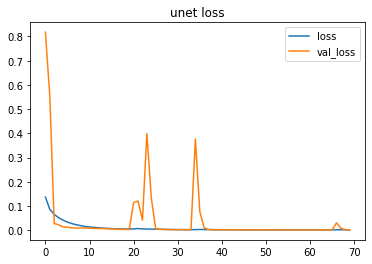

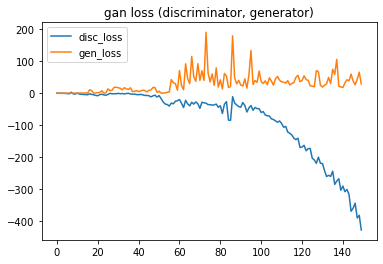

In [34]:
plt.plot(unet_history["loss"])
plt.plot(unet_history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title("unet loss")
plt.show()

plt.plot(gan_history["disc_loss"])
plt.plot(gan_history["gen_loss"])
plt.legend(["disc_loss", "gen_loss"])
plt.title("gan loss (discriminator, generator)")
plt.show()


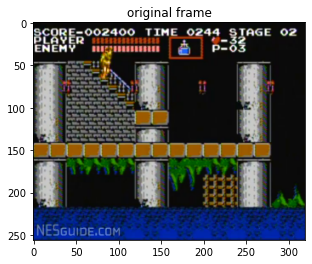

In [35]:
if not GOOGLE_COLAB:
    plt.imshow(first.numpy())
    plt.title("original frame")
else:
    cv2_imshow(first.numpy())

new_frame = frame_predict(unet_m, first, second)
new_frame_gan = frame_predict(gan, first, second)


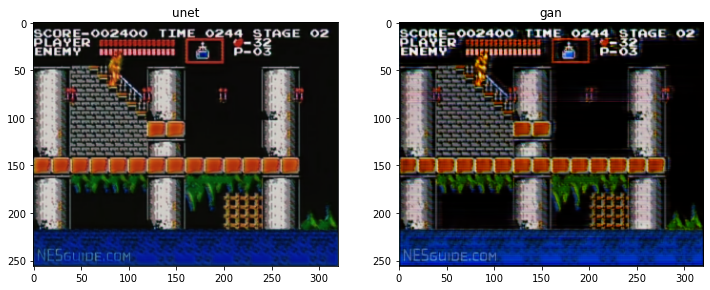

In [36]:
if not GOOGLE_COLAB:
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(new_frame)
    ax1.title.set_text("unet")
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.title.set_text("gan")
    ax2.imshow(new_frame_gan)
    plt.plot()


In [21]:
import itertools

g = frame_gen(filepath + "batman_cut.mp4")


def norm(img):
    return img * 255


def raw_frame_predict(model, f, s):
    input = np.concatenate((f, s), axis=-1)
    input = np.expand_dims(input, axis=0)
    pred = model.predict(input)[0, :, :, :]
    return pred

epochs = 3 # change to influence ho many new frames are going to be generated

def increase_frame_rate(frames, model):
    for i in range(0, epochs):
        new_frames = []
        print("iteration", i)
        for f, s in zip(frames, frames[1:]):
            middle = raw_frame_predict(model, f, s)
            new_frames.extend([f, middle, s])
        frames = new_frames
    return frames


def generate_video(filename, frames, framerate=30):
    out = cv2.VideoWriter(
        filename, cv2.VideoWriter_fourcc(*"DIVX"), framerate, (img_width, img_height)
    )
    for f in frames:
        f = np.uint8(f * 255)
        out.write(f)


In [22]:
original = [x for x in itertools.islice(g, 100)]

frames_gan = increase_frame_rate(original, gan)
frames_unet = increase_frame_rate(original, unet_m)


iteration 0
iteration 1
iteration 2
iteration 0
iteration 1
iteration 2


In [25]:
print(len(original))
generate_video(filepath + "/batman_unet.avi", frames_unet, framerate=60)
generate_video(filepath + "/batman_gan.avi", frames_gan, framerate=60)
generate_video(filepath + "/batman_orig.avi", original, framerate=5)


100
